<a href="https://www.kaggle.com/code/fellahabdelnour13/multi-digit-sequence-recognition?scriptVersionId=198129437" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="font-family:verdana;font-size:2.5rem;text-align:center;">
    Multi-Digit Sequence Recognition With pseudo-synthetically generated data
</div>

<h1 style="font-family:verdana;"> Overview </h1>

1. [Necessary Packages](#necessary_packages)
2. [Constants](#constants)
3. [Reproducibility](#reproducibility)
4. [Dataset](#dataset)
5. [Utils](#utils)
6. [Visualization](#visualization)
7. [Preprocessing](#preprocessing)
8. [The Architecture](#the_architecture)
9. [Loss Function](#loss_function)
10. [Metrics](#metrics)
11. [Training](#training)
12. [Learning curves](#learning_curves)
13. [Making Predictions](#making_predictions)
14. [Thank you :)](#thank_you)

 <div id="necessary_packages" >
     <h1 style="font-family:verdana;">
        Necessary Packages
    </h1>
 </div>

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import random
import numpy as np
import pandas as pd
import math
import seaborn as sns
import warnings
from torch import nn,Tensor,optim
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from typing import Callable,Optional
from torchinfo import summary
from torchmetrics import Metric
from torchmetrics.classification import MulticlassAccuracy
from tqdm.notebook import tqdm
from torch.nn import functional as F

In [2]:
sns.set_style("darkgrid")

In [3]:
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=UserWarning)

<div id="constants" >
    <h1 style="font-family:verdana;">
        Constants
    </h1>
</div>

In [4]:
DATA_DIR = "/kaggle/input/multidigit-mnist"
TRAIN_DIR = os.path.join(DATA_DIR,"train","train")
TEST_DIR = os.path.join(DATA_DIR,"test","test")
NUM_CLASSES = 10
MAX_DIGITS = 5
DIGIT_SIZE = 32

In [5]:
class CONFIG:
    
    ### Reproducibility
    SEED : int = 42
        
    ### Device
    DEVICE : torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    ### Architecture
    STRIDE : int = 16
    KERNEL_SIZE : int = 3
    
    ### DataLoading
    BATCH_SIZE  : int = 32
    NUM_WORKERS : int = 4
    PREFETCH_FACTOR : int | None = 2
        
    ### Hyperparameters
    LEARNING_RATE : float = 1e-3
    WEIGHT_DECAY : float = 0.0
    EPOCHS : int = 10

<div id="reproducibility" >
    <h1 style="font-family:verdana;">
        Reproducibility
    </h1>
</div>

In [6]:
def seed_everything(seed : int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
seed_everything(CONFIG.SEED)

<div id="dataset" >
    <h1 style="font-family:verdana;">
        Dataset
    </h1>
</div>

In [8]:
class MultiDigitMnistDataset(Dataset):
    
    def __init__(self,
        root_dir : int,
        max_digits : int,
        ext : str,
        img_transfrom : Optional[Callable] = None,
        label_transfrom : Optional[Callable] = None
    ) -> None:
        super().__init__()
        
        self.root_dir = root_dir
        self.max_digits = max_digits
        self.ext = ext
        self.files = self._get_filenames()
        self.img_transfrom = img_transfrom
        self.label_transfrom = label_transfrom
        
    def _get_filenames(self) -> list[str]:
        
        files = os.listdir(self.root_dir)
        files = filter(lambda x : os.path.splitext(x)[-1] == self.ext,files)
        files = list(files)
        
        return files
    
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self,index : int) -> tuple[np.ndarray,np.ndarray]:
        
        ### Get the name of the image to load
        filename = self.files[index]
        
        ### Get the label
        label = os.path.splitext(filename)[0].split('_')[-1]
        label = [digit for digit in label]
        label = list(map(int,label))
        label = np.array(label).astype(np.uint8)
        
        ### The image
        path = os.path.join(self.root_dir,filename)
        img = Image.open(path)
        img = np.array(img).astype(np.uint8)
        
        if self.label_transfrom is not None:
            label = self.label_transfrom(label)
            
        if self.img_transfrom is not None:
            img = self.img_transfrom(img)
        
        return img,label

In [9]:
train_data = MultiDigitMnistDataset(root_dir=TRAIN_DIR,max_digits=10,ext=".png")

In [10]:
len(train_data)

50000

In [11]:
next(iter(train_data))

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([7, 8, 0, 5, 5], dtype=uint8))

<div id="utils" >
    <h1 style="font-family:verdana;">
        Utils
    </h1>
</div>

In [12]:
def plot_random_images(dataset : MultiDigitMnistDataset,n : int = 5) -> None:
    
    fig, axes = plt.subplots(nrows=n,figsize=(50,10))
    
    indices = np.arange(len(dataset))
    indices = np.random.choice(indices,size=n,replace=False)
    
    for i in range(n):
        
        index = indices[i]
        img,label = dataset[index]
        ax = axes[i]
        
        ax.imshow(img,cmap='gray')
        ax.set_title(f"Label : {''.join(map(str,label))}")
        
    plt.tight_layout()

In [13]:
def plot_images(images : list,labels : list):
    
    fig, axes = plt.subplots(nrows=len(images),figsize=(50,10))
    
    for ax,image,label in zip(axes,images,labels):
        
        ax.imshow(image,cmap='gray')
        ax.set_title(f"Label : {label}")
        
    plt.tight_layout()

In [14]:
def train(
    model : nn.Module,
    loss_fn : nn.Module,
    train_loader : DataLoader,
    val_loader : DataLoader,
    learning_rate : float,
    weight_decay : float,
    epochs : int,
    metrics : dict[str,Metric],
    device : torch.device,
    show_progress : bool = True,
    verbose : bool = True,
) -> pd.DataFrame:
    
    ### Initialize history
    history = {
        "epoch" : [],
        "split" : [],
        "loss" : []
    }
    
    for metric_name,metric in metrics.items():
        history[metric_name] = []
        metric = metric.to(device)
        
    ### Move the model to the right device
    model = model.to(device)
        
    ### Loss function
    loss_fn = loss_fn.to(device)
    
    ### Optimizer
    optimizer = optim.AdamW(params=model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    
    ### Training
    
    best_metric = 0.0
    
    for epoch in range(epochs):
        
        ### Training Loop
        iterator = tqdm(enumerate(train_loader),total=len(train_loader)) if show_progress else enumerate(train_loader)
        
        if show_progress:
            iterator.set_description(f"Epoch : {(epoch+1)}/{epochs}")
        
        model = model.train()
        running_loss = 0.0
        Y_hat = []
        Y = []
        
        for i,(x,y) in iterator:
            
            ### Move the data to the right device
            x,y = x.to(device),y.to(device)
            
            ### Forward pass
            y_hat = model(x)
            
            ### Loss
            loss = loss_fn(y_hat,y)
            running_loss += loss.item()
            
            ### Zero gradient
            optimizer.zero_grad()
            
            ### Backward pass
            loss.backward()
            
            ### Update the network's weights
            optimizer.step()
            
            ### Update the progress bar
            if show_progress:
                iterator.set_postfix(running_mean_loss=(running_loss / (i+1)))
            
            ### Update the predictions & labels arrays
            Y_hat.append(y_hat.detach())
            Y.append(y.detach())
            
        ### Update the history
        Y_hat = torch.cat(Y_hat)
        Y = torch.cat(Y)
        
        history["epoch"].append(epoch)
        history["split"].append("train")
        history["loss"].append(running_loss/len(train_loader))
        
        for metric_name,metric in metrics.items():
            history[metric_name].append(metric(Y_hat,Y).item())
            
        if verbose:
             message = f"Epoch : {(epoch+1)}/{epochs},Split : train,loss={history['loss'][-1]}," \
                + ",".join([f"{metric_name}={history[metric_name][-1]}" for metric_name in metrics.keys()])
                
             print(message)
                
        del Y_hat,Y
                
        ### Validation Loop
        iterator = tqdm(enumerate(val_loader),total=len(val_loader)) if show_progress else enumerate(val_loader)
        
        if show_progress:
            iterator.set_description(f"Epoch : {(epoch+1)}/{epochs}")
        
        model = model.eval()
        running_loss = 0.0
        Y_hat = []
        Y = []
        
        for i,(x,y) in iterator:
            
            ### Move the data to the right device
            x,y = x.to(device),y.to(device)
            
            ### Forward pass
            y_hat = model(x)
            
            ### Loss
            loss = loss_fn(y_hat,y)
            running_loss += loss.item()
            
            ### Update the predictions & labels arrays
            Y_hat.append(y_hat.detach())
            Y.append(y.detach())
            
        ### Update the history
        Y_hat = torch.cat(Y_hat)
        Y = torch.cat(Y)
        
        history["epoch"].append(epoch)
        history["split"].append("val")
        history["loss"].append(running_loss/len(val_loader))
        
        for metric_name,metric in metrics.items():
            history[metric_name].append(metric(Y_hat,Y).item())
            
        if verbose:
            message = f"Epoch : {(epoch+1)}/{epochs},Split : val,loss={history['loss'][-1]}," \
                + ",".join([f"{metric_name}={history[metric_name][-1]}" for metric_name in metrics.keys()])
            print(message)
            
    history = pd.DataFrame(history)
    
    return history

<div id="visualization" >
    <h1 style="font-family:verdana;">
        Visualization
    </h1>
</div>

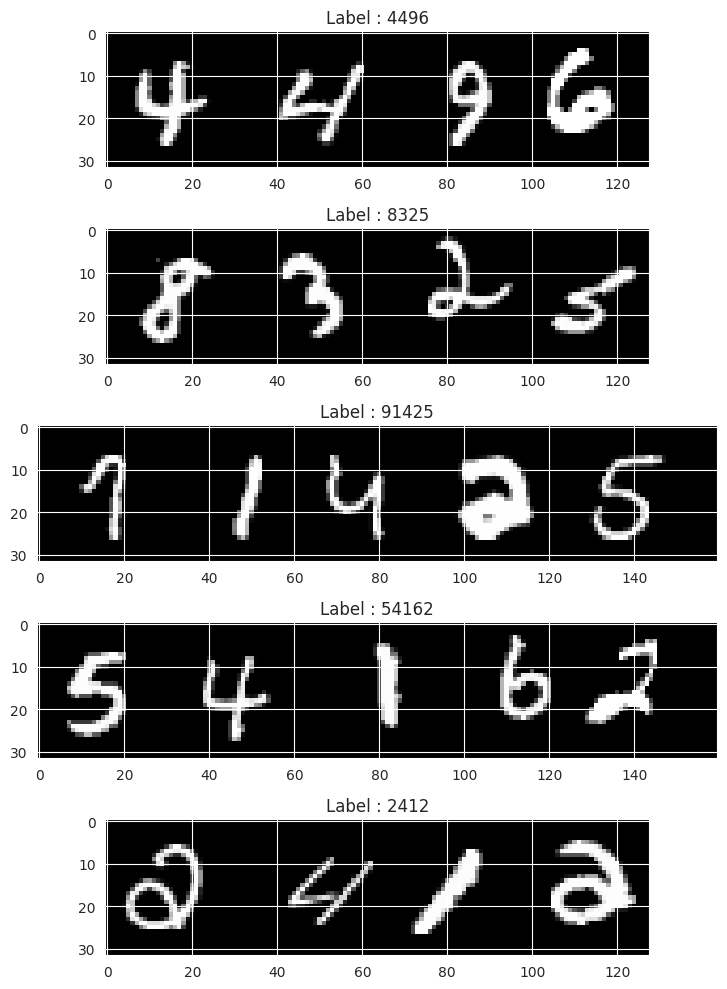

In [15]:
plot_random_images(train_data)

<div id="preprocessing" >
    <h1 style="font-family:verdana;">
        Preprocessing
    </h1>
</div>

In [16]:
x,y = train_data[1]
print(x.shape,y.shape)

(32, 128) (4,)


The `preprocess_label` function is responsible for preparing the label data before it is fed into the model. It ensures that all labels have a consistent length by padding them with a special value (`NUM_CLASSES`) if they are shorter than the maximum number of digits (`MAX_DIGITS`). 

- **Padding:** If the label is shorter than `MAX_DIGITS`, the function pads the label with `NUM_CLASSES`, which acts as a placeholder for non-existent digits. This padding ensures that all labels have the same length.

- **Conversion to Tensor:** After padding, the label is converted into a PyTorch tensor of type `long`, which is the required format for the `cross entropy` loss function.

In [17]:
def preprocess_label(label : np.array) -> Tensor:
    pad = np.ones((MAX_DIGITS - len(label))) * NUM_CLASSES
    label = np.concatenate([pad,label])
    label = torch.tensor(label).long()
    return label

In [18]:
preprocess_label(y)

tensor([10,  4,  8,  7,  8])

The `preprocess_image` function is designed to prepare image data before feeding it into the model. This function standardizes the image size by padding and normalizing it, ensuring consistency across all input images.

- **Padding:** If the width of the image (`W`) is less than the required width (`DIGIT_SIZE * MAX_DIGITS`), the function pads the image with zeros on the left side. This padding ensures that all images have a consistent width, which is critical for processing sequences of digits.

- **Conversion to Tensor:** The padded image is then converted into a PyTorch tensor. The `unsqueeze(0)` operation adds an additional dimension to match the expected input shape for the model (e.g., `1xHxW`), where `1` is the number of channels (grayscale).

- **Normalization:** Finally, the pixel values are normalized by dividing by 255.0, scaling them to the range `[0, 1]`.this step helps with faster and more stable training.

In [19]:
def preporcess_image(img : np.array) -> Tensor:
    H,W = img.shape
    pad = np.zeros((H,DIGIT_SIZE * MAX_DIGITS - W)).astype(np.uint8)
    img = np.concatenate([pad,img],axis=1).astype(np.uint8)
    img = torch.tensor(img).unsqueeze(0)
    img = img / 255.0
    return img

In [20]:
preporcessed_img = preporcess_image(x)
preporcessed_img.shape

torch.Size([1, 32, 160])

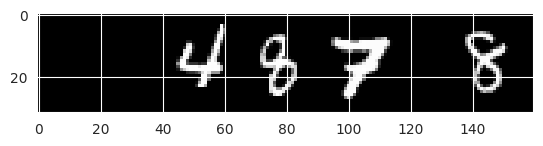

In [21]:
plt.imshow(preporcessed_img[0],cmap="gray")

<div id="the_architecture" >
    <h1 style="font-family:verdana;">
        The Architecture
    </h1>
</div>

**Model Components:**

1. **Backbone (Feature Extractor):**
   - The `Backbone` is a Convolutional Neural Network (CNN) that processes the input images and extracts high-level features.
   - It consists of a series of `BasicCNNBlock` layers, which are composed of convolutional layers, ReLU activations, and max-pooling operations. 
   - The final output of the backbone is a flattened feature vector representing the image.
<br/>
2. **1D Convolutional Layer:**
   - After extracting features with the backbone, the model applies a 1D convolution using the `nn.Conv1d` layer. This layer processes the sequence of features along the digit dimension, learning spatial relationships between the features of different patches.
<br/>
3. **Classifier:**
   - The `classifier` is a fully connected layer (`nn.Linear`) that maps the extracted features to the output classes.

**Forward Pass:**

1. **Image Unfolding:**
   - The input image is unfolded along the width dimension, creating multiple patches that represent different parts of the sequence.
<br/>
2. **Feature Extraction:**
   - The unfolded image patches are passed through the backbone, which extracts features for each patch.
<br/>
3. **Digit Prediction:**
   - The extracted features are then processed by the 1D convolutional layer to capture relationships between consecutive patches.
   - Finally, the classifier outputs predictions for each digit in the sequence.

In [22]:
class BasicCNNBlock(nn.Module):
    
    def __init__(self,
        in_channels : int,
        out_channels : int,
        kernel_size : int,
        stride : int,
        padding : int,
        pool_size : int
    ) -> None:
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
            nn.ReLU(),
            nn.Conv2d(out_channels,out_channels,kernel_size,stride,padding),
            nn.ReLU(),
            nn.MaxPool2d(pool_size)
        )
    
    def forward(self,x : Tensor) -> Tensor:
        return self.block(x)

In [23]:
class Backbone(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.embed_dim = 128
        
        self.backbone = nn.Sequential(
            BasicCNNBlock(1,8,3,1,1,2), # 1x32x32 -> 8x16x16
            BasicCNNBlock(8,16,3,1,1,2), # 8x16x16 -> 16x8x8
            BasicCNNBlock(16,32,3,1,1,2), # 16x8x8 -> 32x4x4
            BasicCNNBlock(32,64,3,1,1,2), # 32x4x4 -> 64x2x2
            BasicCNNBlock(64,128,3,1,1,2), # 64x2x2 -> 128x1x1
            nn.Flatten()
        )
        
    def forward(self,x : Tensor) -> Tensor:
        return self.backbone(x)

In [24]:
class MultiDigitModel(nn.Module):
    
    def __init__(
        self,
        num_classes : int,
        num_digits : int,
        stride : int = 32,
        kernel_size : int = 2,
    ) -> None:
        super().__init__()
        
        self.num_classes = num_classes
        self.num_digits = num_digits
        self.stride = stride
        self.channels_count = int(math.ceil((32 * num_digits - 32)) / stride + 1)
        self.kernel_size = kernel_size
        
        self.backbone = Backbone()
        
        self.conv1d = nn.Conv1d(self.channels_count,self.num_digits,self.kernel_size,1,padding="same")
                
        self.classifier = nn.Linear(self.backbone.embed_dim,self.num_classes)
        
    def forward(self,x : Tensor) -> Tensor:
        
        x = x.unfold(-1,32,self.stride) # 1x1x32x160 -> 1x1x32x32x5
        x = torch.permute(x, (0,3,1,2,4)) # 1x1x32x32x5 -> 1x5x1x32x32
        B,N,C,H,W = x.size()
        
        x = torch.reshape(x,(B * N,C,H,W)) # 1x5x1x32x32 -> 5x1x32x32
        
        features = self.backbone(x) # 1x5x1x32x32 -> 5x128
        features = torch.reshape(features,(B,N,self.backbone.embed_dim)) # 5x128 -> 1x5x128
        
        features = self.conv1d(features)
        
        y = self.classifier(features)
        
        return y

In [25]:
model = MultiDigitModel(NUM_CLASSES+1,MAX_DIGITS,CONFIG.STRIDE,CONFIG.KERNEL_SIZE)
x = torch.zeros(32,1,32,32*5)
summary(model,input_data=x,device="cpu",depth=5)

Layer (type:depth-idx)                        Output Shape              Param #
MultiDigitModel                               [32, 5, 11]               --
├─Backbone: 1-1                               [288, 128]                --
│    └─Sequential: 2-1                        [288, 128]                --
│    │    └─BasicCNNBlock: 3-1                [288, 8, 16, 16]          --
│    │    │    └─Sequential: 4-1              [288, 8, 16, 16]          --
│    │    │    │    └─Conv2d: 5-1             [288, 8, 32, 32]          80
│    │    │    │    └─ReLU: 5-2               [288, 8, 32, 32]          --
│    │    │    │    └─Conv2d: 5-3             [288, 8, 32, 32]          584
│    │    │    │    └─ReLU: 5-4               [288, 8, 32, 32]          --
│    │    │    │    └─MaxPool2d: 5-5          [288, 8, 16, 16]          --
│    │    └─BasicCNNBlock: 3-2                [288, 16, 8, 8]           --
│    │    │    └─Sequential: 4-2              [288, 16, 8, 8]           --
│    │    │    │   

<div id="loss_function" >
    <h1 style="font-family:verdana;">
        Loss function
    </h1>
</div>

- As a loss function we will use the `CrossEntropyLoss`,but since we are in mutli-label classification problem (our network is outputting `N` predictions one for each digit),we reshape the tensors.

In [26]:
class Seq2SeqCrossEntropyLoss(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cel = nn.CrossEntropyLoss()
        
    def forward(self,inputs : Tensor,targets : Tensor) -> Tensor:
                
        B,N = targets.shape

        inputs = torch.reshape(inputs,(B*N,-1))
        targets = torch.reshape(targets,(B*N,-1)).squeeze()
                
        return self.cel(inputs,targets)

<div id="metrics" >
    <h1 style="font-family:verdana;">
        Metrics
    </h1>
</div>

- The `Seq2SeqPartialAccuracy` class is designed to compute the partial accuracy for sequence-to-sequence (Seq2Seq) models, where each element in a sequence is predicted separately, and we want to evaluate the accuracy for each element individually.

In [27]:
class Seq2SeqPartialAccuracy:
    
    def __init__(self,num_classes : int) -> None:
        self.acc = MulticlassAccuracy(num_classes=num_classes)
        
    def __call__(self,inputs : Tensor,targets : Tensor) -> Tensor:
                
        B,N = targets.shape

        inputs = torch.reshape(inputs,(B*N,-1))
        targets = torch.reshape(targets,(B*N,-1)).squeeze()
                
        return self.acc(inputs,targets)
        
    def to(self,device : torch.device) -> 'Seq2SeqAccuracy':
        self.acc = self.acc.to(device)
        return self

- The `Seq2SeqAccuracy` class is designed to compute the exact sequence-level accuracy for sequence-to-sequence (Seq2Seq) models. This metric evaluates whether the entire predicted sequence matches the target sequence exactly.

In [28]:
class Seq2SeqAccuracy:
    
    def __init__(self):
        pass
    
    def __call__(self,inputs : Tensor,targets : Tensor) -> Tensor:
        
        hard_preds = torch.argmax(inputs,dim=-1).squeeze()
        
        acc = targets - hard_preds
        acc = acc.sum(dim=-1)
        acc = (acc == 0.0).float().mean()
        
        return acc
    
    def to(self,device : torch.device) -> 'Seq2SeqAccuracy':
        return self

<div id="training" >
    <h1 style="font-family:verdana;">
        Training
    </h1>
</div>

In [29]:
train_data = MultiDigitMnistDataset(root_dir=TRAIN_DIR,max_digits=10,ext=".png",img_transfrom=preporcess_image,label_transfrom=preprocess_label)
test_data = MultiDigitMnistDataset(root_dir=TEST_DIR,max_digits=10,ext=".png",img_transfrom=preporcess_image,label_transfrom=preprocess_label)

In [30]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True,
    num_workers=CONFIG.NUM_WORKERS,
    prefetch_factor=CONFIG.PREFETCH_FACTOR
)

In [31]:
test_loader = DataLoader(
    dataset=test_data,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False,
    num_workers=CONFIG.NUM_WORKERS,
    prefetch_factor=CONFIG.PREFETCH_FACTOR
)

In [32]:
history = train(
    model=model,
    loss_fn=Seq2SeqCrossEntropyLoss(),
    train_loader=train_loader,
    val_loader=test_loader,
    learning_rate=CONFIG.LEARNING_RATE, 
    weight_decay=CONFIG.WEIGHT_DECAY, 
    epochs=CONFIG.EPOCHS, 
    metrics={
        "accuracy" : Seq2SeqAccuracy(),
        "partial-accuracy" : Seq2SeqPartialAccuracy(num_classes=NUM_CLASSES+1)
    }, 
    device=CONFIG.DEVICE, 
    show_progress=True, 
    verbose=True
)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 1/10,Split : train,loss=1.1244579634306833,accuracy=0.32617998123168945,partial-accuracy=0.49168622493743896


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1/10,Split : val,loss=0.087878941656492,accuracy=0.8703999519348145,partial-accuracy=0.9649066925048828


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 2/10,Split : train,loss=0.06497848843121859,accuracy=0.9066599607467651,partial-accuracy=0.9743828773498535


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2/10,Split : val,loss=0.05331870193069521,accuracy=0.9226999878883362,partial-accuracy=0.9787527918815613


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 3/10,Split : train,loss=0.03798647240939075,accuracy=0.9422599673271179,partial-accuracy=0.984570324420929


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3/10,Split : val,loss=0.03887656687523801,accuracy=0.9417999982833862,partial-accuracy=0.9842907190322876


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 4/10,Split : train,loss=0.029324383455856275,accuracy=0.9562999606132507,partial-accuracy=0.9883643388748169


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4/10,Split : val,loss=0.037577034109986175,accuracy=0.9442999958992004,partial-accuracy=0.9850611686706543


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 5/10,Split : train,loss=0.023605602641024025,accuracy=0.9639999866485596,partial-accuracy=0.9903935194015503


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5/10,Split : val,loss=0.03009620132951286,accuracy=0.9566999673843384,partial-accuracy=0.9884546399116516


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 6/10,Split : train,loss=0.0196037229153755,accuracy=0.969819962978363,partial-accuracy=0.9919759631156921


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6/10,Split : val,loss=0.02735676518388497,accuracy=0.9591999650001526,partial-accuracy=0.988976240158081


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 7/10,Split : train,loss=0.017220604690837527,accuracy=0.9736199975013733,partial-accuracy=0.9929583668708801


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7/10,Split : val,loss=0.024051043832136805,accuracy=0.9645999670028687,partial-accuracy=0.9905834197998047


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 8/10,Split : train,loss=0.015616585177854516,accuracy=0.9767799973487854,partial-accuracy=0.9938520193099976


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8/10,Split : val,loss=0.02804379148226337,accuracy=0.9617999792098999,partial-accuracy=0.9897618293762207


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 9/10,Split : train,loss=0.014087527567432551,accuracy=0.9785199761390686,partial-accuracy=0.9942396283149719


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9/10,Split : val,loss=0.023642071054460995,accuracy=0.9670999646186829,partial-accuracy=0.9912909269332886


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch : 10/10,Split : train,loss=0.012700733656013596,accuracy=0.9809799790382385,partial-accuracy=0.9949096441268921


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10/10,Split : val,loss=0.023707813299249876,accuracy=0.9646999835968018,partial-accuracy=0.9906198382377625


<div id="learning_curves" >
   <h1 style="font-family:verdana;">
        Learning curves
    </h1> 
</div>

In [33]:
history

,epoch,split,loss,accuracy,partial-accuracy
0,0,train,1.124458,0.32618,0.491686
1,0,val,0.087879,0.87040,0.964907
2,1,train,0.064978,0.90666,0.974383
3,1,val,0.053319,0.92270,0.978753
4,2,train,0.037986,0.94226,0.984570
5,2,val,0.038877,0.94180,0.984291
6,3,train,0.029324,0.95630,0.988364
7,3,val,0.037577,0.94430,0.985061
8,4,train,0.023606,0.96400,0.990394
9,4,val,0.030096,0.95670,0.988455


<Axes: xlabel='epoch', ylabel='loss'>

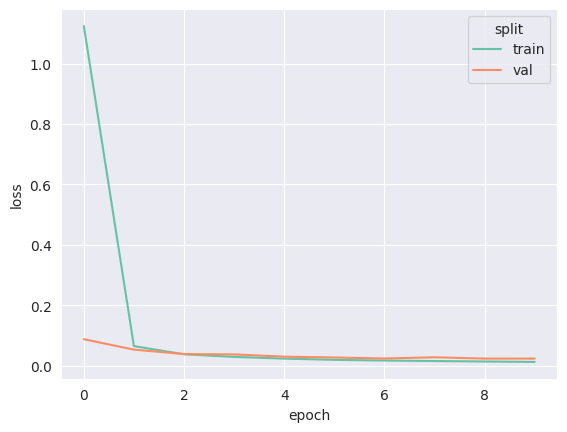

In [34]:
sns.lineplot(data=history,x="epoch",y="loss",hue="split",palette="Set2")

<Axes: xlabel='epoch', ylabel='accuracy'>

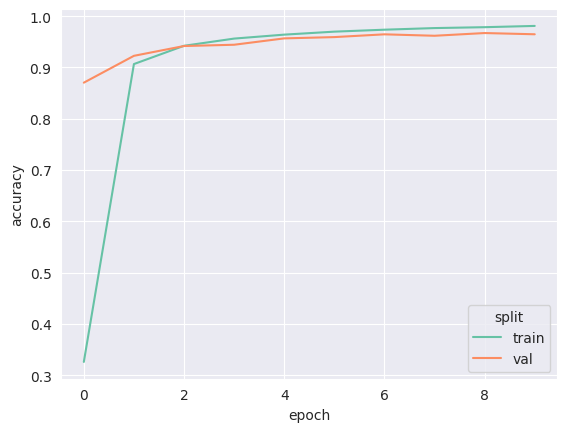

In [35]:
sns.lineplot(data=history,x="epoch",y="accuracy",hue="split",palette="Set2")

<Axes: xlabel='epoch', ylabel='partial-accuracy'>

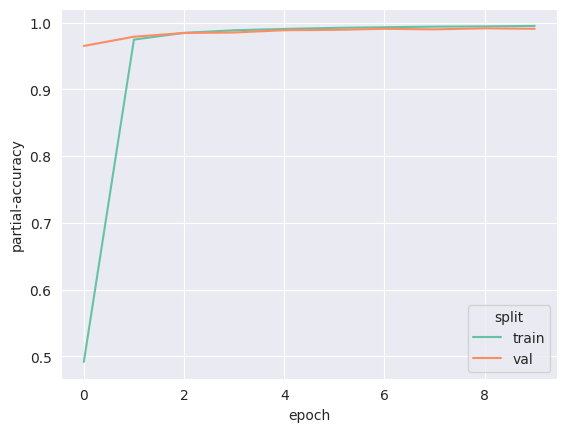

In [36]:
sns.lineplot(data=history,x="epoch",y="partial-accuracy",hue="split",palette="Set2")

<div id="making_predictions" >
    <h1 style="font-family:verdana;">
        Making Predictions
    </h1>
</div>

In [37]:
def predict(model : MultiDigitModel,x : Tensor) -> list[int]:
    
    model = model.eval()
    
    labels = []
    
    with torch.inference_mode():
        
        x = x.to(CONFIG.DEVICE)
        
        y = model(x)
        y = torch.argmax(y,dim=-1)
        y = y.detach().cpu().numpy()
        
        for label in y:
            
            label = label[label != model.num_classes - 1]
            label = label.tolist()
            label = list(map(str,label))
            label = ''.join(label)
            label = int(label)
            
            labels.append(label)
            
    return labels

In [38]:
images,real_labels = next(iter(test_loader))
images,real_labels = images[:5],real_labels[:5]

In [39]:
predicted_labels = predict(model, images)

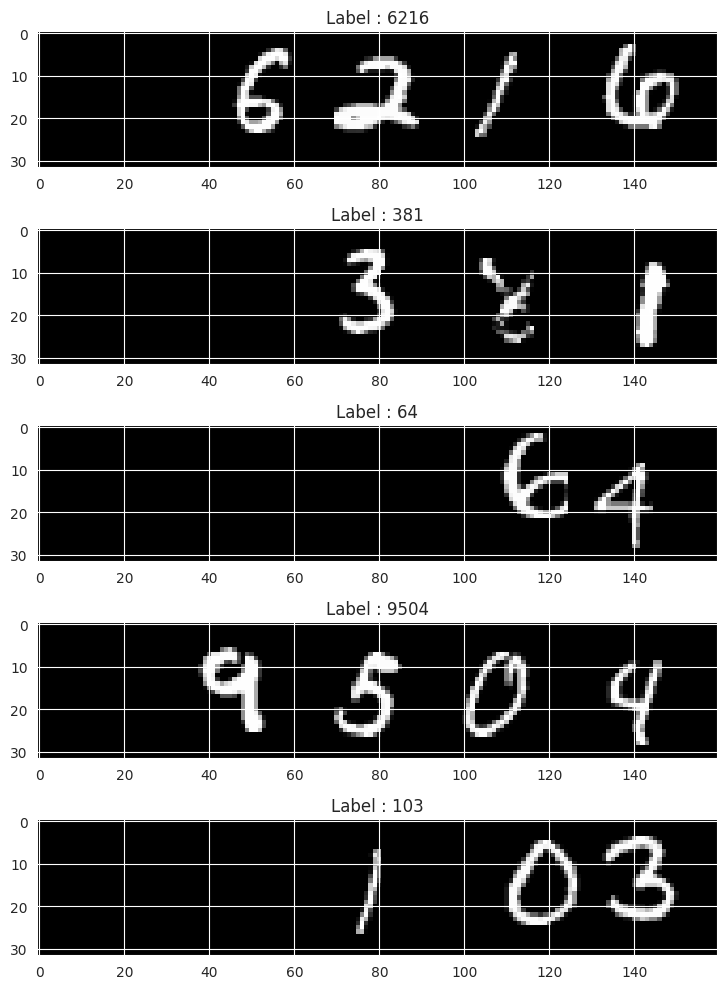

In [40]:
plot_images(images.squeeze().numpy(),predicted_labels)

<div id="thank_you" >
    <h1 style="font-family:verdana;">
        Thank you :)
    </h1>
</div>